In [1]:
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csc_matrix

from sgp import KGgraphrnd

%matplotlib inline

## Constructing a random KG from two CRMs

In [2]:
alpha = 100
beta = 1
sigma_alpha = 0.5
sigma_beta = 0.5
tau_alpha = 1.
tau_beta = 1.
sampled_graph = KGgraphrnd(alpha, beta, sigma_alpha, sigma_beta, tau_alpha, tau_beta)
T = sampled_graph[0]

/Users/arongdari/workspace/sparse-graph-prior/sgp/GGPrnd.py:81: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  N = np.zeros(np.ceil(Njumps + 3 * np.sqrt(Njumps)))


In [3]:
n_r = len(T); n_e = T[0].shape[0]

### Basic stats:

In [4]:
print('number of relations: %d\nnumber of entities: %d\nnumber of triples %d\n' % (n_r, n_e, np.sum([t.sum() for t in T])))

number of relations: 127
number of entities: 2444
number of triples 16893



### Number of triples for each relation:

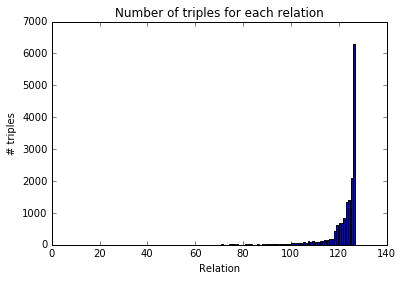

In [5]:
n_triples = np.zeros(n_r)
for i in range(n_r):
    n_triples[i] = T[i].sum()
plt.bar(np.arange(n_r), n_triples)
plt.title('Number of triples for each relation')
plt.xlabel('Relation')
plt.ylabel('# triples')

## Computing a growth rate of triples w.r.t the number of randomly selected entities

In [6]:
n_triple = defaultdict(list)
n_sample = 10 # repeat counting n_sample times

for s in range(n_sample):
    tic = time.time()
    n_triple[0].append(0)
    
    shuffled_e = np.arange(n_e)
    np.random.shuffle(shuffled_e)
    _colT = list()
    _rowT = list()
    for r in range(n_r):
        _colT.append(T[r][np.ix_(shuffled_e, shuffled_e)].tocsc())
        _rowT.append(T[r][np.ix_(shuffled_e, shuffled_e)].tocsr())
    
    for i in range(1, n_e):
        # counting triples by expanding tensor
        cnt = 0
        for k in range(n_r):
            cnt += _rowT[k].getrow(i)[:,:i].nnz
            cnt += _colT[k].getcol(i)[:i-1,:].nnz            
        n_triple[i].append(n_triple[i-1][-1] + cnt)
        
    print(time.time()-tic)
avg_cnt = [np.mean(n_triple[i]) for i in range(n_e)]

221.5790090560913
213.56519293785095
217.34069991111755
217.23723101615906
205.22890090942383
205.94492101669312
205.06926012039185
209.18389296531677
218.77108502388
219.32589602470398


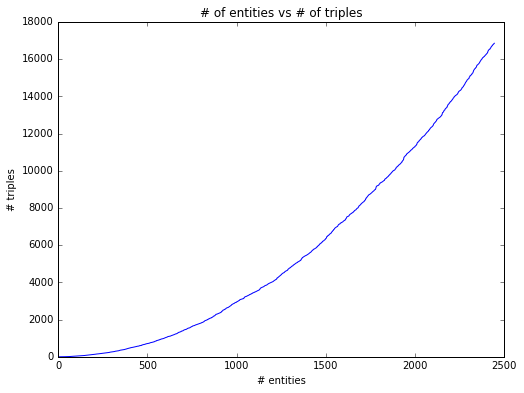

In [9]:
plt.figure(figsize=(8,6))
plt.plot(avg_cnt, label='empirical')
plt.title('# of entities vs # of triples')
plt.xlabel('# entities')
plt.ylabel('# triples')

(0, 18000)

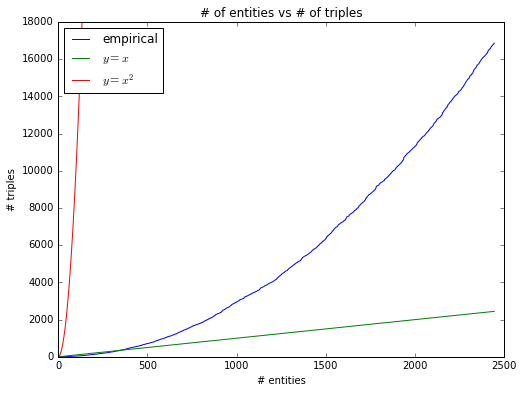

In [11]:
plt.figure(figsize=(8,6))
plt.plot(avg_cnt, label='empirical')
plt.title('# of entities vs # of triples')
plt.xlabel('# entities')
plt.ylabel('# triples')

first_order = [x for x in range(n_e)]
second_order = [x**2 for x in range(n_e)]
plt.plot(first_order, label='$y=x$')
plt.plot(second_order, label='$y=x^2$')
plt.legend(loc='upper left')
plt.ylim([0, 18000])